# Explore the Transformed Play by Play Data

## Setup - Paths - Dependencies

In [63]:
from config import recent_play_by_play, recent_clean_db

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import os

from config import recent_play_by_play, recent_clean_db, last_game_date, tourney_bubble

## Load Play by Play data
pbp_raw_df = pd.read_csv(recent_play_by_play, low_memory=False)


data_folder = os.path.join('..', 'data') # data folder
temp_folder = os.path.join('..', 'TEMP') # temp folder
# pbp_folder = os.path.join(data_folder, 'vault', 'play_by_play_extracts') # pbp folder

# pbp_raw_df.head()


#### Hotfix Clean Team Names - Create and Stand Second Team
- Need to Incorporate the secondary team thing upstream in scraper

In [64]:
#### HOTFIX TO CLEAN 

### Drop games Exhibition games from dataset
# see two problem teams St Anselm and Assumption - if Game_ID contains either of the teams drop the row
pbp_raw_df = pbp_raw_df[~pbp_raw_df['Game_ID'].str.contains('St Anselm|Assumption')]

# Fix Problem with a few Primary_team values
# Substitute 'UCN' and 'UCN Gustafsson' with 'Connecticut'
pbp_raw_df.loc[pbp_raw_df['Primary_team'] == 'UCN', 'Primary_team'] = 'Connecticut'
pbp_raw_df.loc[pbp_raw_df['Primary_team'] == 'UCN Gustafsson', 'Primary_team'] = 'Connecticut'
# Replace the weird 'PRI de la' with 'Princeton'
pbp_raw_df.loc[pbp_raw_df['Primary_team'] == 'PRI de la', 'Primary_team'] = 'Princeton'


### HOTFIX TO ADD SECONDARY TEAM TO EVERY ROW
df = pbp_raw_df
# Create a new column 'Secondary_team' and initialize it with None
df['Secondary_team'] = None
# Loop through each row in the DataFrame
for index, row in df.iterrows():
    # Extract the game ID
    game_id = row['Game_ID']
    # Determine the home and away teams based on the game ID
    away_team = game_id.split('-')[3]
    home_team = game_id.split('-')[4]
    # Assign the opposite team to the 'Secondary_team' column based on the 'Primary_team'
    if row['Primary_team'] == home_team:
        df.at[index, 'Secondary_team'] = away_team
    else:
        df.at[index, 'Secondary_team'] = home_team

# Hotfix to replace any '.' with ''
df['Primary_team'] = df['Primary_team'].str.replace('.', '', regex=False)
df['Secondary_team'] = df['Secondary_team'].str.replace('.', '', regex=False)

pbp_raw_df = df


# ### HOTFIX TO DEAL WITH St. Cloud State having the period when it shouldn't
# # if St. Cloud State is in Primary_team or Secondary_team replace with 'St Cloud State'BaseExceptionGroup
# pbp_raw_df.loc[pbp_raw_df['Primary_team'] == 'St. Cloud State', 'Primary_team'] = 'St Cloud State'
# pbp_raw_df.loc[pbp_raw_df['Secondary_team'] == 'St. Cloud State', 'Secondary_team'] = 'St Cloud State'



#### Functions 
- jitter_duplicates

In [65]:
## Set a Default Jitter Amount - IS ADJUSTED DOWN IN THE VIZ SETTINGS
global_jitter_amount = 0.2

def jitter_duplicates(plot_df, x_col, y_col, jitter_amount=0.2):
    """
    Adds slight jitter to duplicate (x, y) coordinate pairs to prevent overlapping.
    
    Parameters:
        plot_df (pd.DataFrame): Dataframe containing x and y coordinates.
        x_col (str): Name of the x-axis column.
        y_col (str): Name of the y-axis column.
        jitter_amount (float): Maximum jitter to apply (default 0.2).
        
    Returns:
        pd.DataFrame: Dataframe with adjusted coordinates.
    """
    coord_counts = plot_df.groupby([x_col, y_col]).size().reset_index(name='count')
    
    # Apply jitter to duplicates
    for _, row in coord_counts.iterrows():
        if row['count'] > 1:
            mask = (plot_df[x_col] == row[x_col]) & (plot_df[y_col] == row[y_col])
            num_duplicates = mask.sum()
            jitter_x = np.linspace(-jitter_amount, jitter_amount, num_duplicates)
            jitter_y = np.linspace(-jitter_amount, jitter_amount, num_duplicates)
            np.random.shuffle(jitter_x)
            np.random.shuffle(jitter_y)
            plot_df.loc[mask, x_col] += jitter_x
            plot_df.loc[mask, y_col] += jitter_y
    
    return plot_df

# Data Exlporation

#### Shots Blocked, Missed, On Target, Goal Comparison between the two datasets

In [66]:
### Database connection to get player_ytd stats and advanced stats tables
import sqlite3

conn = sqlite3.connect(recent_clean_db)

# get list of tables in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

# Load advanced metrics as am_df
am_df = pd.read_sql_query("SELECT * FROM advanced_metrics", conn)

# Load player_ytd as py_df
ytd_df = pd.read_sql_query("SELECT * FROM player_stats_ytd", conn)

# close the connection
conn.close()

# CHECK DATA
# print(am_df.head())
print(am_df.shape)
print(am_df.columns)

print(am_df.dtypes) # Data types


# print db path
print(recent_clean_db)

               name
0  player_stats_ytd
1     master_roster
2  advanced_metrics
3      game_details
4      goalie_stats
5        line_chart
6         linescore
7   penalty_summary
8      player_stats
9   scoring_summary
(40262, 25)
Index(['Team', 'Player', 'TOTAL_Block', 'TOTAL_Miss', 'TOTAL_Saved',
       'TOTAL_Goals', 'TOTAL_Total_Shots', 'EVEN_Block', 'EVEN_Miss',
       'EVEN_Saved', 'EVEN_Goals', 'EVEN_Total_Shots', 'PP_Block', 'PP_Miss',
       'PP_Saved', 'PP_Goals', 'PP_Total_Shots', 'CLOSE_Block', 'CLOSE_Miss',
       'CLOSE_Saved', 'CLOSE_Goals', 'CLOSE_Total_Shots', 'D_Blocks',
       'Faceoffs', 'Game_ID'],
      dtype='object')
Team                 object
Player               object
TOTAL_Block          object
TOTAL_Miss           object
TOTAL_Saved          object
TOTAL_Goals          object
TOTAL_Total_Shots    object
EVEN_Block           object
EVEN_Miss            object
EVEN_Saved           object
EVEN_Goals           object
EVEN_Total_Shots     object
PP_Block      

In [67]:
# Set datatypes for am_df 

# Create new Dataframe with just team TOTALS
am_team_df = am_df[am_df['Player'] == 'TOTAL']
# DROP Rows where Player: TOTAL
am_df = am_df[am_df['Player'] != 'TOTAL']

    
# Columns to convert to int & fill nans with 0
int_columns = ('TOTAL_Block', 'TOTAL_Miss', 'TOTAL_Saved',
'TOTAL_Goals', 'TOTAL_Total_Shots', 'EVEN_Block', 'EVEN_Miss',
'EVEN_Saved', 'EVEN_Goals', 'EVEN_Total_Shots', 'PP_Block', 'PP_Miss',
'PP_Saved', 'PP_Goals', 'PP_Total_Shots', 'CLOSE_Block', 'CLOSE_Miss',
'CLOSE_Saved', 'CLOSE_Goals', 'CLOSE_Total_Shots', 'D_Blocks')

# Fill empty strings with 0
am_df = am_df.replace('', 0)
# Convert columns to int and fill nans with 0
def col_int_columns(df, int_columns):
    for col in int_columns:
        df[col] = df[col].replace('', 0)
        df[col] = df[col].astype(int)
# Run on each df
col_int_columns(am_df, int_columns)
col_int_columns(am_team_df, int_columns)

# print am_df dtypes again
# print(am_df.dtypes) # Data types

# # list columns in am_df
# print(am_df.columns)

# columns to aggregate
# 'Team', 'Player', 'TOTAL_Block', 'TOTAL_Miss', 'TOTAL_Saved', 'TOTAL_Goals', D_Blocks

### USE SQL TO AGGREGATE THE DATA and bring it into pandas
# Create a new dataframe with the aggregated values for each player - Groupby Team and Player

# ### Create a new dataframe with the aggregated values for each player - Groupby Team and Player
def aggregate_df(df):
    df_grouped = df.groupby(['Team', 'Player']).agg({
        'TOTAL_Block': 'sum',
        'TOTAL_Miss': 'sum',
        'TOTAL_Saved': 'sum',
        'TOTAL_Goals': 'sum',
        'D_Blocks': 'sum'
    }).reset_index()

    # Create new column for Total Shots on net (Goals + Saved)
    df_grouped['TOTAL_Shots_ON'] = df_grouped['TOTAL_Goals'] + df_grouped['TOTAL_Saved']
    # Sort By TOTAL_GOALS
    df_grouped = df_grouped.sort_values(by='TOTAL_Goals', ascending=False)
    return df_grouped

#### RUN THE FUNCTION ON BOTH DATAFRAMES
am_df_grouped = aggregate_df(am_df)
# print am_df_grouped shape and columns
# print(am_df_grouped.shape)
# print(am_df_grouped.columns)
# # print am_df_grouped head
# am_df_grouped.head()

### Do the same for am_team_df
am_team_df_grouped = aggregate_df(am_team_df)
# print am_team_df_grouped shape and columns
print(am_team_df_grouped.shape)
print(am_team_df_grouped.columns)
# print am_team_df_grouped head
am_team_df_grouped.head()



(64, 8)
Index(['Team', 'Player', 'TOTAL_Block', 'TOTAL_Miss', 'TOTAL_Saved',
       'TOTAL_Goals', 'D_Blocks', 'TOTAL_Shots_ON'],
      dtype='object')


,Team,Player,TOTAL_Block,TOTAL_Miss,TOTAL_Saved,TOTAL_Goals,D_Blocks,TOTAL_Shots_ON
36,Minnesota,TOTAL,490,564,1067,135,415,1202
20,Denver,TOTAL,430,490,928,129,303,1057
4,Arizona State,TOTAL,374,354,922,118,460,1040
50,Quinnipiac,TOTAL,486,442,843,117,368,960
40,Niagara,TOTAL,471,354,1004,115,466,1119


In [68]:
#### Call play by play data is pbp_df
pbp_df = pbp_raw_df



## Faceoff Danger
- Table of how many times a team has scored within 3,5, 7, and 10 seconds of a faceoff

In [69]:
# Rename to df for convenience
df = pbp_raw_df

# Filter for relevant events: Faceoffs and Goals
faceoff_events = df[df['Event_type'] == 'Faceoff']
goal_events = df[df['Event_type'] == 'Goal']

# Merge faceoff events with subsequent goal events within the same game and period
merged_df = pd.merge(
    faceoff_events[['Game_ID', 'Period', 'Time', 'Primary_team']],
    goal_events[['Game_ID', 'Period', 'Time', 'Primary_team']],
    on=['Game_ID', 'Period'],
    suffixes=('_faceoff', '_goal')
)

# Calculate the time difference between faceoff and goal
merged_df['time_diff'] = merged_df['Time_goal'] - merged_df['Time_faceoff']

# Filter only instances where the goal happens after the faceoff
merged_df = merged_df[merged_df['time_diff'] > 0]


# Count how often a goal is scored within 10 seconds and 5 seconds of a faceoff
goals_within_10s = (merged_df['time_diff'] <= 10).sum()
goals_within_5s = (merged_df['time_diff'] <= 5).sum()

# Count the number of times each team has scored a goal within 5 seconds of a faceoff
teams_scoring_within_5s = merged_df[merged_df['time_diff'] <= 5]['Primary_team_goal'].value_counts()

# Display results
# goals_within_10s, goals_within_5s, teams_scoring_within_5s


In [70]:
# Recalculate the time difference properly
merged_df = pd.merge(
    faceoff_events[['Game_ID', 'Period', 'Time', 'Primary_team']],
    goal_events[['Game_ID', 'Period', 'Time', 'Primary_team']],
    on=['Game_ID', 'Period'],
    suffixes=('_faceoff', '_goal')
)

# Ensure that the goal occurs after the faceoff in time
merged_df = merged_df[merged_df['Time_goal'] > merged_df['Time_faceoff']]

# Calculate the correct time difference between faceoff and goal
merged_df['time_diff'] = merged_df['Time_goal'] - merged_df['Time_faceoff']

# Count goals per team in different time frames
teams_goal_counts = merged_df.groupby('Primary_team_goal')['time_diff'].agg(
    Scored_within_1s=lambda x: (x <= 1).sum(),
    Scored_within_2s=lambda x: (x <= 2).sum(),
    Scored_within_3s=lambda x: (x <= 3).sum(),
    Scored_within_4s=lambda x: (x <= 4).sum(),
    Scored_within_5s=lambda x: (x <= 5).sum(),
    Scored_within_6s=lambda x: (x <= 6).sum(),
    Scored_within_7s=lambda x: (x <= 7).sum(),
    Scored_within_8s=lambda x: (x <= 8).sum(),
    Scored_within_9s=lambda x: (x <= 9).sum(),
    Scored_within_10s=lambda x: (x <= 10).sum()
).reset_index()

# Add the total goals scored by each team
total_goals_per_team = goal_events['Primary_team'].value_counts().reset_index()
total_goals_per_team.columns = ['Primary_team_goal', 'Total_Goals']

# Merge with the team goal counts
teams_goal_counts = teams_goal_counts.merge(total_goals_per_team, on='Primary_team_goal', how='left')



In [71]:
teams_goal_counts.head()

,Primary_team_goal,Scored_within_1s,Scored_within_2s,Scored_within_3s,Scored_within_4s,Scored_within_5s,Scored_within_6s,Scored_within_7s,Scored_within_8s,Scored_within_9s,Scored_within_10s,Total_Goals
0,Air Force,0,0,0,2,3,3,5,6,7,9,72
1,Alaska,0,1,1,3,4,6,6,6,8,9,67
2,Alaska Anchorage,0,0,0,1,1,2,2,3,3,3,67
3,American Intl,0,0,0,0,1,1,1,2,2,5,76
4,Arizona State,0,0,0,1,3,3,3,3,3,5,111


In [72]:
# Calculate the percentage for each goal duration
for sec in range(1, 11):
    col = f'Scored_within_{sec}s'
    pct_col = f'{col}_pct'
    teams_goal_counts[pct_col] = teams_goal_counts[col] / teams_goal_counts['Total_Goals']

# Rearrange columns in an interleaved order: original value then its percentage
cols = ['Primary_team_goal', 'Total_Goals'] + [
    item for sec in range(1, 11)
    for item in (f'Scored_within_{sec}s', f'Scored_within_{sec}s_pct')
]
teams_goal_counts = teams_goal_counts[cols]

# Rename Primary_team_goal to Team
teams_goal_counts.rename(columns={'Primary_team_goal': 'Team'}, inplace=True)

In [73]:
# team_goal_counts.sample(10)

In [74]:
# 

### Goals Allowed Just after faceoffs

In [75]:
## Reset df to a clean copy of the full pbp data
df = pbp_raw_df

# Fill the Secondary team column with the opposite team 
# If the Primary team is 'Home', the Secondary team is 'Away' and vice versa based on Game_ID
# Away is after third '-' in game_id. home is after 4th
# check primary team against game id and put opposite in secondary

# # Create a new column 'Secondary_team' and initialize it with None
# df['Secondary_team'] = None
# # Loop through each row in the DataFrame
# for index, row in df.iterrows():
#     # Extract the game ID
#     game_id = row['Game_ID']
#     # Determine the home and away teams based on the game ID
#     away_team = game_id.split('-')[3]
#     home_team = game_id.split('-')[4]
#     # Assign the opposite team to the 'Secondary_team' column based on the 'Primary_team'
#     if row['Primary_team'] == home_team:
#         df.at[index, 'Secondary_team'] = away_team
#     else:
#         df.at[index, 'Secondary_team'] = home_team


# Filter for relevant events: Faceoffs and Goals
faceoff_events = df[df['Event_type'] == 'Faceoff']
goal_events = df[df['Event_type'] == 'Goal']

# Check the first few rows to verify the new column
# df.head()

In [76]:

# Merge faceoff events with subsequent goal events within the same game and period
merged_allowed_df = pd.merge(
    faceoff_events[['Game_ID', 'Period', 'Time', 'Primary_team', 'Secondary_team']],
    goal_events[['Game_ID', 'Period', 'Time', 'Primary_team', 'Secondary_team']],
    on=['Game_ID', 'Period'],
    suffixes=('_faceoff', '_goal')
)

# Calculate the time difference between faceoff and goal
merged_allowed_df['time_diff'] = merged_allowed_df['Time_goal'] - merged_allowed_df['Time_faceoff']

# Filter only instances where the goal happens after the faceoff
merged_allowed_df = merged_allowed_df[merged_allowed_df['time_diff'] > 0]

merged_allowed_df.head()
# Count goals per team in different time frames
teams_goal_allowed = merged_allowed_df.groupby('Secondary_team_goal')['time_diff'].agg(
    within_1s=lambda x: (x <= 1).sum(),
    within_2s=lambda x: (x <= 2).sum(),
    within_3s=lambda x: (x <= 3).sum(),
    within_4s=lambda x: (x <= 4).sum(),
    within_5s=lambda x: (x <= 5).sum(),
    within_6s=lambda x: (x <= 6).sum(),
    within_7s=lambda x: (x <= 7).sum(),
    within_8s=lambda x: (x <= 8).sum(),
    within_9s=lambda x: (x <= 9).sum(),
    within_10s=lambda x: (x <= 10).sum()
).reset_index()

## LEGACY
# Add the total goals scored by each team 
# total_goals_per_team = goal_events['Secondary_team'].value_counts().reset_index()
# total_goals_per_team.columns = ['Secondary_team', 'Total_Goals']

# Merge with the team goal counts
 

# teams_goal_allowed.head()



In [77]:
# Add the season total of goals allowed by each team
total_goals_allowed_per_team = goal_events['Secondary_team'].value_counts().reset_index()
total_goals_allowed_per_team.columns = ['Secondary_team_goal', 'Total_Goals_Allowed']

# add the data into the teams_goal_allowed dataframe
teams_goal_allowed = teams_goal_allowed.merge(total_goals_allowed_per_team, on='Secondary_team_goal', how='left')


### Merge Two Datatables

In [78]:
# Rename columns for clarity in the allowed goals DataFrame
teams_goal_allowed.columns = ['Team', 'Allowed_within_1s', 'Allowed_within_2s', 'Allowed_within_3s',
                               'Allowed_within_4s', 'Allowed_within_5s', 'Allowed_within_6s', 'Allowed_within_7s',
                               'Allowed_within_8s', 'Allowed_within_9s', 'Allowed_within_10s', 'Total_Goals_Allowed']

# Check the data
teams_goal_allowed.sample(10)


,Team,Allowed_within_1s,Allowed_within_2s,Allowed_within_3s,Allowed_within_4s,Allowed_within_5s,Allowed_within_6s,Allowed_within_7s,Allowed_within_8s,Allowed_within_9s,Allowed_within_10s,Total_Goals_Allowed
11,Bowling Green,0,0,0,0,2,4,5,5,5,6,73
37,Minnesota Duluth,0,0,1,1,3,4,5,7,9,11,87
10,Boston University,0,0,1,1,1,1,2,3,3,4,93
19,Dartmouth,0,0,1,2,3,3,3,3,5,5,68
25,Lindenwood,0,0,0,1,1,2,2,4,8,11,80
17,Connecticut,0,0,0,2,4,7,7,7,9,11,73
42,Northeastern,0,1,1,1,4,5,5,6,7,7,72
5,Army,0,0,0,1,1,2,3,3,6,8,96
60,Union,0,0,0,2,2,3,4,4,6,6,89
3,American Intl,0,1,3,4,7,7,7,8,9,10,94


In [79]:
# # Merge the allowed goals DataFrame with the total goals DataFrame
# face_off_goal_success = teams_goal_allowed.merge(teams_goal_counts, on='Team', how='left')
# Calculate the percentage for each goal duration
# Define the seconds list to include 1-10, 15, 20, and 30 seconds
secs = list(range(1, 11))

for sec in secs:
    col = f'Allowed_within_{sec}s'
    pct_col = f'{col}_pct'
    teams_goal_allowed[pct_col] = teams_goal_allowed[col] / teams_goal_allowed['Total_Goals_Allowed']
# Merge the allowed goals DataFrame with the total goals DataFrame
face_off_goal_success = teams_goal_allowed.merge(teams_goal_counts, on='Team', how='left')




In [80]:
# face_off_goal_success.info()

### Save the Faceoff Success Table

In [81]:
## Save Final Table to Data Folder

# face_off_goal_success.to_csv(os.path.join(pbp_folder, f'face_off_goal_success_{play_by_play_filename}.csv'), index=False)

# Examine table
# face_off_goal_success.head(10)

# Check info
# face_off_goal_success.info()

## AFTER PP SUCCESS - Within 10 seconds of end of PP

In [82]:
### Get all relevant rows from pbp data
# Filter for relevant events: PP-Start, PP-End and Goals
df = pbp_raw_df

# Filter for relevant events: PP-Start, PP-End and Goals
pp_start_events = df[df['Event_type'] == 'PP - Start']
pp_end_events = df[df['Event_type'] == 'PP - End']
goal_events = df[df['Event_type'] == 'Goal']
# Merge PP-Start events with subsequent goal events within the same game and period
merged_pp_df = pd.merge(
    pp_start_events[['Game_ID', 'Period', 'Time', 'Primary_team']],
    goal_events[['Game_ID', 'Period', 'Time', 'Primary_team']],
    on=['Game_ID', 'Period'],
    suffixes=('_pp_start', '_goal')
)

# Calculate the time difference between PP-Start and goal
merged_pp_df['time_diff'] = merged_pp_df['Time_goal'] - merged_pp_df['Time_pp_start']
# Filter only instances where the goal happens after the PP-End
merged_pp_df = merged_pp_df[merged_pp_df['time_diff'] > 0]
# Count goals per team in different time frames
teams_goal_pp = merged_pp_df.groupby('Primary_team_goal')['time_diff'].agg(
    Scored_within_1s=lambda x: (x <= 1).sum(),
    Scored_within_2s=lambda x: (x <= 2).sum(),
    Scored_within_3s=lambda x: (x <= 3).sum(),
    Scored_within_4s=lambda x: (x <= 4).sum(),
    Scored_within_5s=lambda x: (x <= 5).sum(),
    Scored_within_6s=lambda x: (x <= 6).sum(),
    Scored_within_7s=lambda x: (x <= 7).sum(),
    Scored_within_8s=lambda x: (x <= 8).sum(),
    Scored_within_9s=lambda x: (x <= 9).sum(),
    Scored_within_10s=lambda x: (x <= 10).sum(),
    Scored_within_15s=lambda x: (x <= 15).sum(),
    Scored_within_20s=lambda x: (x <= 20).sum(),
    Scored_within_30s=lambda x: (x <= 30).sum()
).reset_index()

# Add the total goals scored by each team
total_goals_per_team = goal_events['Primary_team'].value_counts().reset_index()
total_goals_per_team.columns = ['Primary_team_goal', 'Total_Goals']
# Merge with the team goal counts
teams_goal_pp = teams_goal_pp.merge(total_goals_per_team, on='Primary_team_goal', how='left')

# Calculate the percentage for each goal duration
# Define the seconds list to include 1-10, 15, 20, and 30 seconds
secs = list(range(1, 11)) + [15, 20, 30]

# Calculate the percentage for each goal duration
for sec in secs:
    col = f'Scored_within_{sec}s'
    pct_col = f'{col}_pct'
    teams_goal_pp[pct_col] = teams_goal_pp[col] / teams_goal_pp['Total_Goals']

# Rearrange columns in an interleaved order: original value then its percentage
cols = ['Primary_team_goal', 'Total_Goals'] + [
    item for sec in secs
    for item in (f'Scored_within_{sec}s', f'Scored_within_{sec}s_pct')
]
teams_goal_pp = teams_goal_pp[cols]

# Rename Primary_team_goal to Team
teams_goal_pp.rename(columns={'Primary_team_goal': 'Team'}, inplace=True)
# teams_goal_pp.head(10)
# teams_goal_pp.info(10)

In [83]:
### Count how many Power Play goals each team has scored by looking at the 'Goal_Conditions' column of pbp_raw_df 
# # if it contains POWER-PLAY it is a PP Goal


# Count how many Power Play goals each team has scored by looking at the 'Goal_Conditions' column of pbp_raw_df
# # if it contains POWER-PLAY it is a PP Goal
# Initialize a DataFrame to store the counts
pp_goal_counts = pd.DataFrame(columns=['Team', 'PP_Goals'])
# Loop through each team
for team in df['Primary_team'].unique():
    # Count the number of goals for the team that contain 'POWER-PLAY' in 'Goal_Conditions'
    pp_goals = df[(df['Primary_team'] == team) & (df['Goal_Conditions'].str.contains('POWER-PLAY', na=False))]
    pp_goal_counts = pd.concat([pp_goal_counts, pd.DataFrame({'Team': [team], 'PP_Goals': [len(pp_goals)]})])

# Reset the index
pp_goal_counts.reset_index(drop=True, inplace=True)
# Merge the PP goal counts with the main DataFrame
teams_goal_pp = teams_goal_pp.merge(pp_goal_counts, on='Team', how='left')
# Check the data
# teams_goal_pp.sample(10)




#### Goals Allowed Just after End of PP

In [84]:
### Do the same for allowed goals
# Merge PP-End events with subsequent goal events within the same game and period
merged_pp_allowed_df = pd.merge(
    pp_end_events[['Game_ID', 'Period', 'Time', 'Primary_team', 'Secondary_team']],
    goal_events[['Game_ID', 'Period', 'Time', 'Primary_team', 'Secondary_team']],
    on=['Game_ID', 'Period'],
    suffixes=('_pp_end', '_goal')
)

# Calculate the time difference between PP-End and goal
merged_pp_allowed_df['time_diff'] = merged_pp_allowed_df['Time_goal'] - merged_pp_allowed_df['Time_pp_end']
# Filter only instances where the goal happens after the PP-End
merged_pp_allowed_df = merged_pp_allowed_df[merged_pp_allowed_df['time_diff'] > 0]
# Count goals per team in different time frames
teams_goal_pp_allowed = merged_pp_allowed_df.groupby('Primary_team_goal')['time_diff'].agg(
    Allowed_within_1s=lambda x: (x <= 1).sum(),
    Allowed_within_2s=lambda x: (x <= 2).sum(),
    Allowed_within_3s=lambda x: (x <= 3).sum(),
    Allowed_within_4s=lambda x: (x <= 4).sum(),
    Allowed_within_5s=lambda x: (x <= 5).sum(),
    Allowed_within_6s=lambda x: (x <= 6).sum(),
    Allowed_within_7s=lambda x: (x <= 7).sum(),
    Allowed_within_8s=lambda x: (x <= 8).sum(),
    Allowed_within_9s=lambda x: (x <= 9).sum(),
    Allowed_within_10s=lambda x: (x <= 10).sum(),
    Allowed_within_15s=lambda x: (x <= 15).sum(),
    Allowed_within_20s=lambda x: (x <= 20).sum(),
    Allowed_within_30s=lambda x: (x <= 30).sum()
).reset_index()

# Rename Primary_team_goal to Team
teams_goal_pp_allowed.rename(columns={'Primary_team_goal': 'Team'}, inplace=True)
# Add the total goals allowed by each team
total_goals_allowed_per_team = goal_events['Secondary_team'].value_counts().reset_index()
total_goals_allowed_per_team.columns = ['Secondary_team', 'Total_Goals_Allowed']
# Rename to simply Team
total_goals_allowed_per_team.rename(columns={'Secondary_team': 'Team'}, inplace=True)

total_goals_allowed_per_team
# Merge with the team goal counts
teams_goal_pp_allowed = teams_goal_pp_allowed.merge(total_goals_allowed_per_team, on='Team', how='left')

# teams_goal_pp_allowed.head()
# teams_goal_pp_allowed.info()

# # look at mean min and max
# teams_goal_pp_allowed.describe()




In [85]:
## Calculate the percentage for each goal duration
# Define the seconds list to include 1-10, 15, 20, and 30 seconds
secs = list(range(1, 11)) + [15, 20, 30]

# Calculate the percentage for each goal duration
for sec in secs:
    col = f'Allowed_within_{sec}s'
    pct_col = f'{col}_pct'
    teams_goal_pp_allowed[pct_col] = teams_goal_pp_allowed[col] / teams_goal_pp_allowed['Total_Goals_Allowed']

# Rearrange columns in an interleaved order: original value then its percentage
cols = ['Team', 'Total_Goals_Allowed'] + [
    item for sec in secs
    for item in (f'Allowed_within_{sec}s', f'Allowed_within_{sec}s_pct')
]
teams_goal_pp_allowed = teams_goal_pp_allowed[cols]
# Merge the allowed goals DataFrame with the total goals DataFrame
face_off_allowed_goal_pp = teams_goal_pp_allowed.merge(teams_goal_pp, on='Team', how='left')
# face_off_allowed_goal_pp.head(10)

In [86]:
## Count the number of PP goals allowed by each team and add to the DataFrame
# Initialize a DataFrame to store the counts
pp_goal_allowed_counts = pd.DataFrame(columns=['Team', 'PP_Goals_Allowed'])
# Loop through each team
for team in df['Secondary_team'].unique():
    # Count the number of goals for the team that contain 'POWER-PLAY' in 'Goal_Conditions'
    pp_goals_allowed = df[(df['Secondary_team'] == team) & (df['Goal_Conditions'].str.contains('POWER-PLAY', na=False))]
    pp_goal_allowed_counts = pd.concat([pp_goal_allowed_counts, pd.DataFrame({'Team': [team], 'PP_Goals_Allowed': [len(pp_goals_allowed)]})])
# Reset the index
pp_goal_allowed_counts.reset_index(drop=True, inplace=True)

# Merge the PP goal counts with the main DataFrame
teams_goal_pp_allowed = teams_goal_pp_allowed.merge(pp_goal_allowed_counts, on='Team', how='left')
# Check the data
# teams_goal_pp_allowed.sample(10)

In [87]:
## Merge the Scored and allowed datasets into a single final table
# Merge the scored and allowed DataFrames
post_power_play_success = teams_goal_pp_allowed.merge(teams_goal_pp, on='Team', how='left')
# Check the data
# post_power_play_success.sample(10)

#### Save Post PP Data to CSV File in Vault

In [88]:
### Save Final Table to PBP Extract Folder
# post_power_play_success.to_csv(os.path.join(pbp_folder, f'post_power_play_success_{play_by_play_filename}.csv'), index=False)

# Visualizations

### Helper functions and legacy code from Team Comp workbook

In [89]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


## File Paths

### BACKGROUND IMAGE
#### Set Background Image
path_to_bg_image =  'main1.png' #
alpha_value = 0.1 # Set the transparency of the background image
# Load the background image
# bg_img = mpimg.imread(background_folder + path_to_bg_image)
# images\background\main1.png
# bg_img = mpimg.imread('../../images/background/main1.png') # Add '.. string to the path

# Add '.. string to the path
# bg_img = rotate(bg_img, 90) # Rotate the image

## Special Beanpot BG
path_to_bg_image =  'Beanpot_transparent_850px.png' #
background_folder = '../Beanpot/' # Beanpot Folder Path
bg_img = mpimg.imread(background_folder + path_to_bg_image)
print(background_folder + path_to_bg_image)



folder_prefix = ''
# folder_prefix = '..'
data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
TEMP_FOLDER = temp_folder # Temp Folder Path as used in legacy code
output_folder = os.path.join(temp_folder, 'faceoff_comp_output/') # Output Folder Path
# data\db\2024_Dec_10_CLEANED_OLD_METHOD.db
# db_path = os.path.join(data_folder, 'db', '2025_Jan_26_CLEAN.db') # Database Path
db_path = recent_clean_db # Database Path

image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path
bg_img = mpimg.imread('../images/background/main1.png') # Add '.. string to the path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path


../Beanpot/Beanpot_transparent_850px.png


In [90]:
## Load the school info to get hex codes, logo files, and other info
school_info_df = pd.read_csv(school_info_path)


# Remove punctuation from the school names (dashes with spaces, . and ' with nothing)
school_info_df['Team'] = school_info_df['Team'].str.replace('-', ' ')
school_info_df['Team'] = school_info_df['Team'].str.replace('.', '')
school_info_df['Team'] = school_info_df['Team'].str.replace("'", '')
# school_info_df.head() # Check the data

# # Create a color dictionary with just the primary (hex1) and secondary (hex2) colors from the school info
# Team: hex1, hex2
# Drop unused columns
school_color_df = school_info_df[['Team', 'hex1', 'hex2']]
color_mapping = school_color_df.set_index('Team').T.to_dict('list')
# color_mapping # Show dictionary
## MAY NEED TO ADD LEADING/ TRAILING zeros to the hex codes

# Create a dictionary of school logos
# Team: logo + '.png'

# Hotfix to deal with 2 teams that have '.' still in names
# Replace St. Lawerence with St Lawrence
school_info_df['Team'] = school_info_df['Team'].str.replace('St. Lawerence', 'St Lawrence')
school_info_df['Team'] = school_info_df['Team'].str.replace('St. Thomas', 'St Thomas')
# Drop unused columns
school_logo_df = school_info_df[['Team', 'logo_abv']]
school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'
logo_mapping = school_logo_df.set_index('Team')['logo_abv'].to_dict()
# logo_mapping # Check the dictionary




C:\Users\jbanc\AppData\Local\Temp\ipykernel_11172\1827423332.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  color_mapping = school_color_df.set_index('Team').T.to_dict('list')
C:\Users\jbanc\AppData\Local\Temp\ipykernel_11172\1827423332.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'


In [91]:
## NEW SUB FUNCTION 3/24/24
def add_logos_to_plot(data_df, x_col, y_col, logo_mapping, logo_folder, ax, teams_in_region):
    # Plot logos for specific teams
    for team in teams_in_region:
        team_data = data_df[data_df['Team'] == team]
        if not team_data.empty:
            x = team_data[x_col].values[0]
            y = team_data[y_col].values[0]
            logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
            if logo_path:
                try:
                    logo_img = plt.imread(logo_path)
                    imagebox = OffsetImage(logo_img, zoom=0.15)  # Adjust zoom as needed
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(0, 0), boxcoords="offset points", pad=0)
                    ax.add_artist(ab)  # Apply the ax here as the artist is being added to ax
                except Exception as e:
                    print(f"Error adding logo for {team}: {e}")




In [92]:
def clean_color_mapping(color_mapping):
    """
    Cleans and validates color codes in the color_mapping dictionary.
    Ensures all colors are valid hex codes starting with '#'.

    Parameters:
    - color_mapping (dict): A dictionary where the key is the team name and the value is a list of hex colors.

    Returns:
    - cleaned_mapping (dict): A dictionary with properly formatted hex color codes.
    """
    cleaned_mapping = {}
    for team, colors in color_mapping.items():
        cleaned_colors = []
        for color in colors:
            if isinstance(color, str):
                # Ensure it starts with '#' and is a valid hex color code
                color = color.strip()
                if not color.startswith('#'):
                    color = f'#{color}'
                if len(color) == 7 and all(c in '0123456789ABCDEFabcdef' for c in color[1:]):
                    cleaned_colors.append(color)
                else:
                    # Use a fallback color if invalid
                    cleaned_colors.append('#000000')  # Default to black for invalid colors
            else:
                cleaned_colors.append('#000000')  # Default to black for non-string values
        cleaned_mapping[team] = cleaned_colors
    return cleaned_mapping

# Clean and validate the color mapping
color_mapping = clean_color_mapping(color_mapping)

# Now the color_mapping dictionary has valid hex color codes



### Figure Size and Font Settings

In [93]:
## Set the value for the amount of jitter (offset when logos are overlapping) 
# # HIGHER => MORE SPREAD OUT
global_jitter_amount = 0.2

# figure_size = square_fig

#### INSTAGRAM SIZE - Portrait
dpi = 600
width, height = 1080, 1350  # in pixels
# figure_size = (width / dpi, height / dpi)  # in inches
figure_size = (10,10)

font = "Exo 2"
size1 = 24
size2 = 20
size3 = 16
size4 = 12
size5 = 8
large_tick_label_size = 20
# Set up Font Parameters that are used in some of the legacy code
## FONT PARAMETERS

font_title_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_label_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size2}
font_tick_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size3}
font_label_large_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': large_tick_label_size}
font_tick_large_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': large_tick_label_size}
font_tag_parm = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_tag_parm_2 = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_note_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size5}
font_tick_param_small = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size4}


## Set the column widths for the table in the scatter plots
col_widths = [0.30, 0.225, 0.225]  # Adjust the values as needed

In [94]:
from matplotlib import font_manager



## Load The Exo 2 font in case of problems with the font
font_path = 'C:/Windows/Fonts/Exo 2.tff'
locations =['../data/Exo_2'] # Font Location

font_files = font_manager.findSystemFonts(fontpaths=locations)

for file in font_files:
    font_manager.fontManager.addfont(file)


### Conference Member Dictionary

In [95]:
########### Custom Groups ##########

# Minnesota at Michigan State for 1-25-25
minnesota_michigan_state = ['Michigan State', 'Minnesota']
minnesota_michigan_state_logo_mapping = {team: logo_mapping.get(team, '') for team in minnesota_michigan_state}

# B1G top 5 - Jan 21 2025
b1g_top_5 = ['Michigan State', 'Minnesota', 'Ohio State', 'Michigan', 'Wisconsin']
### USCHO Top 5 - (1-16-25)
uscho_top_5 = ['Michigan State', 'Boston College', 'Minnesota', 'Western Michigan', 'Maine']
uscho_top_5_logo_mapping = {team: logo_mapping.get(team, '') for team in uscho_top_5}

# NCHC Top 5 - Jan 16
nchc_top_5 = ['North Dakota', 'Arizona State', 'Western Michigan',  'Denver', 'Omaha']
nchc_top_5_logo_mapping = {team: logo_mapping.get(team, '') for team in nchc_top_5}

### In season Tourney Groups

# Four Team Group (GLI)
gli_teams = ['Michigan Tech', 'Western Michigan', 'Michigan State', 'Northern Michigan']
gli_logo_mapping = {team: logo_mapping.get(team, '') for team in gli_teams}

# Four Team Group (Beanpot)
beanpot_teams = ['Harvard', 'Boston University', 'Boston College', 'Northeastern']
beanpot_logo_mapping = {team: logo_mapping.get(team, '') for team in beanpot_teams}

# Kwick Trip Faceoff - Wis hosted Dec 28-29
kwik_trip_teams = ["Wisconsin", "Ferris State", "Connecticut", "Alaska"]
kwik_trip_logo_mapping = {team: logo_mapping.get(team, '') for team in kwik_trip_teams}

# Desert Hockey Classic - ASU hosted Jan 3-4
desert_classic_teams = ["Arizona State", "Robert Morris", "Cornell", "Massachusetts" ]
desert_classic_logo_mapping = {team: logo_mapping.get(team, '') for team in desert_classic_teams}

# Auld Lang Syne - Dec 28-29
auld_lang_teams = ["Dartmouth", "Alaska Anchorage", "Northeastern", "Providence"]
auld_lang_logo_mapping = {team: logo_mapping.get(team, '') for team in auld_lang_teams}

## Test BC to see why opp score seems inncorrect
bc_test_teams = ["Boston College"]
bc_test_logo_mapping = {team: logo_mapping.get(team, '') for team in bc_test_teams}


In [96]:
# Get list of every team in the dataset 
all_teams = df['Primary_team'].unique().tolist()

# Define the conferences
conference_teams_mens = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill'],
    'GLI': gli_teams,
    'Beanpot': beanpot_teams,
    'Kwik Trip': kwik_trip_teams,
    'Desert Classic': desert_classic_teams,
    'Auld Lang Syne': auld_lang_teams,
    'Great Lakes Invitational': gli_teams,
    'Test BC': bc_test_teams,
    'USCHO Top 5': uscho_top_5,
    'NCHC Top 5': nchc_top_5,
    'B1G Top 5': b1g_top_5,
    'Minnesota at Michigan State': minnesota_michigan_state,
    "2025 Dunkin' Beanpot": beanpot_teams,
    # All teams In the NCAA - add the list of all 7 conferences
    'Full 64': all_teams,
    'NCAA At-Large Contenders': tourney_bubble
    

}

# Load conference logos - Mens
conference_logo_mapping_mens = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}

### Conference Membersip - Women's D1
w_atlantic = ['Lindenwood', 'Mercyhurst', 'Penn State', 
            'RIT', 'Robert Morris', 'Syracuse']
w_ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']
w_hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Holy Cross', 
                'Maine', 'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']
w_newha = ['Assumption', 'Franklin Pierce', 'Long Island', 'Post', 'Sacred Heart',
        'Saint Anselm', 'Saint Michaels', 'Stonehill']
w_wcha = ['Bemidji State', 'Minnesota', 'Minnesota Duluth', 'Minnesota State', 'Ohio State', 
            'St Cloud State', 'St Thomas', 'Wisconsin']

conference_teams_womens = {
    'Atlantic': w_atlantic,
    'ECAC': w_ecac,
    'Hockey East': w_hockey_east,
    'NewHA': w_newha,
    'WCHA': w_wcha
}
conference_logo_mapping_womens = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}

## Team Blocked Shots - For and Against
- Scatter Plot

#### Get the total shots each team has given up 

In [117]:
# ls_df.head() # Check the data
teams_to_plot = conference_teams_mens['Full 64'] # Set the teams to plot
# teams_to_plot = all_teams

In [118]:
# Get line_score table from database
# Open the database connection
conn = sqlite3.connect(db_path)
ls_df = pd.read_sql_query("SELECT * FROM linescore", conn)
conn.close() # Close the database connection

ls_df.head() # Check the data


# GOAL: Get a Table with Team and the number of goals and shots they have allowed
## - Need to look at unique Game_IDs
#    - assign the team that scored the goal to the team that allowed the goal and so on with shots

# Goals each team scored in the unique game is in goalsT column, Shots Take in shotsT column
# There is no column for shots and goals allowed, so we need to create them by looking at the other team in the game


def get_goal_shot_alloweds_v2(ls_df):
    """
    Get the number of goals and shots allowed by each team.

    Parameters:
    - df (DataFrame): The DataFrame containing the play-by-play data.
    - ls_df (DataFrame): The DataFrame containing the linescore data.

    Returns:
    - DataFrame: A DataFrame with the number of goals and shots allowed by each team.
    """
    # Initialize a DataFrame to store the counts
    goal_shot_allowed_counts = pd.DataFrame(columns=['Team', 'Games_Played', 
                                            'Goals_Allowed', 'Shots_Allowed',
                                            'Goals_Scored', 'Shots_Taken'])
    # Loop through each unique game
    for game_id in ls_df['Game_ID'].unique():
        # Get the teams in the game
        teams = ls_df[ls_df['Game_ID'] == game_id]['Team'].unique()
        # Get the goals and shots for each team
        for team in teams:
            # Get the goals and shots for the team
            goals = ls_df[(ls_df['Game_ID'] == game_id) & (ls_df['Team'] == team)]['goalsT'].values[0]
            shots = ls_df[(ls_df['Game_ID'] == game_id) & (ls_df['Team'] == team)]['shotsT'].values[0]
            # Get the other team
            other_team = [t for t in teams if t != team][0]
            # Add the data to the DataFrame
            goal_shot_allowed_counts = pd.concat([goal_shot_allowed_counts, pd.DataFrame({'Team': [other_team], 
                                                                                        'Games_Played': 1, 
                                                                                        'Goals_Allowed': goals, 
                                                                                        'Shots_Allowed': shots,
                                                                                        'Goals_Scored': 0,
                                                                                        'Shots_Taken': 0})])
            goal_shot_allowed_counts = pd.concat([goal_shot_allowed_counts, pd.DataFrame({'Team': [team], 
                                                                                        'Games_Played': 1, 
                                                                                        'Goals_Allowed': 0, 
                                                                                        'Shots_Allowed': 0,
                                                                                        'Goals_Scored': goals,
                                                                                        'Shots_Taken': shots})])
    # Reset the index
    goal_shot_allowed_counts.reset_index(drop=True, inplace=True)
    # Group by team and sum the goals and shots
    goal_shot_allowed_counts = goal_shot_allowed_counts.groupby('Team').sum().reset_index()

    # # Find the number of games played by each team by looking at the number of rows in the original DataFrame
    # games_played = ls_df.groupby('Team')['Game_ID'].nunique().reset_index()
    # games_played.columns = ['Team', 'Games_Played']

    
    # Calculate the goals and shots per game
    # HOTFIX, GAMES PLAYED WAS IS DOUBLE COUNTED
    goal_shot_allowed_counts['Games_Played'] = goal_shot_allowed_counts['Games_Played'] * 0.5
    goal_shot_allowed_counts['Goals_Allowed_per_Game'] = goal_shot_allowed_counts['Goals_Allowed'] / goal_shot_allowed_counts['Games_Played']
    goal_shot_allowed_counts['Shots_Allowed_per_Game'] = goal_shot_allowed_counts['Shots_Allowed'] / goal_shot_allowed_counts['Games_Played']   
    goal_shot_allowed_counts['Goals_Scored_per_Game'] = goal_shot_allowed_counts['Goals_Scored'] / goal_shot_allowed_counts['Games_Played']
    goal_shot_allowed_counts['Shots_Taken_per_Game'] = goal_shot_allowed_counts['Shots_Taken'] / goal_shot_allowed_counts['Games_Played']

    # Return the DataFrame
    return goal_shot_allowed_counts

# Get the goals and shots allowed by each team
goal_shot_allowed_counts = get_goal_shot_alloweds_v2(ls_df)
# goal_shot_allowed_counts.head(10) # Check the data

In [119]:
## MERGE THE AM_TEAM_DF WITH THE GOAL_SHOT_ALLOWED_COUNTS DF
# columns to take from the goal_shot_allowed_counts df
## Games_Played, Goals_Allowed, Shots_Allowed, Goals_Scored, Shots_Taken
am_team_df_grouped = am_team_df_grouped.merge(goal_shot_allowed_counts[['Team', 'Games_Played', 'Goals_Allowed', 
                                                                            'Shots_Allowed', 'Goals_Scored', 
                                                                            'Shots_Taken']], on='Team', how='left')

## Take Data from Advanced_States_Team_Grouped Table
# am_team_df_grouped.head()

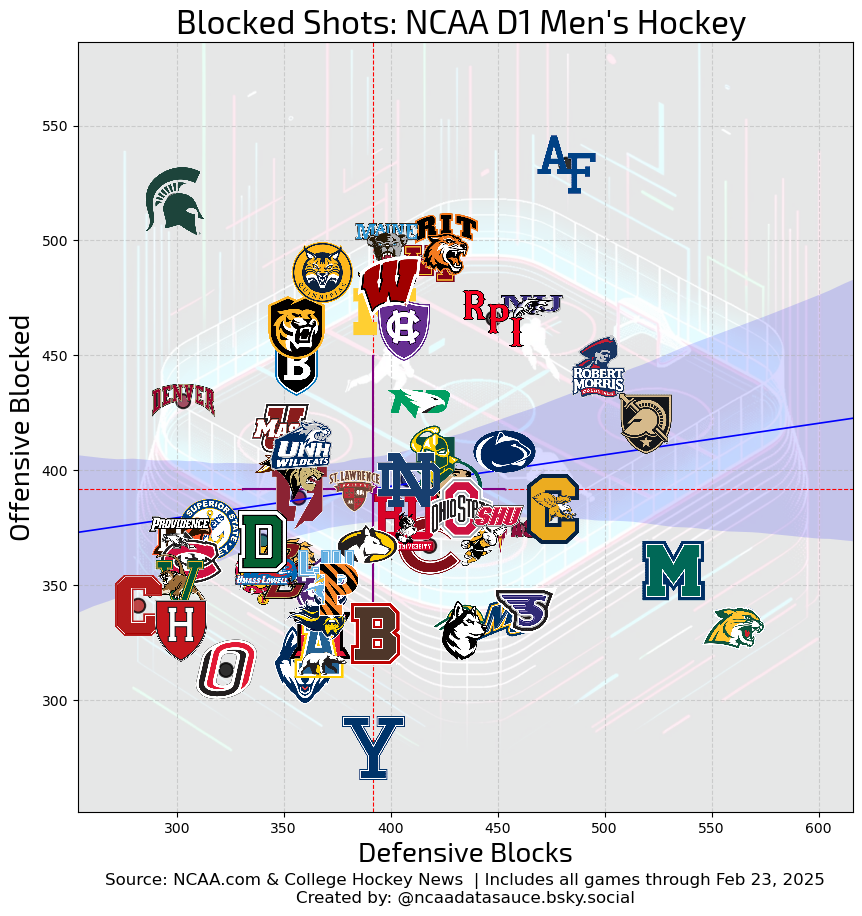

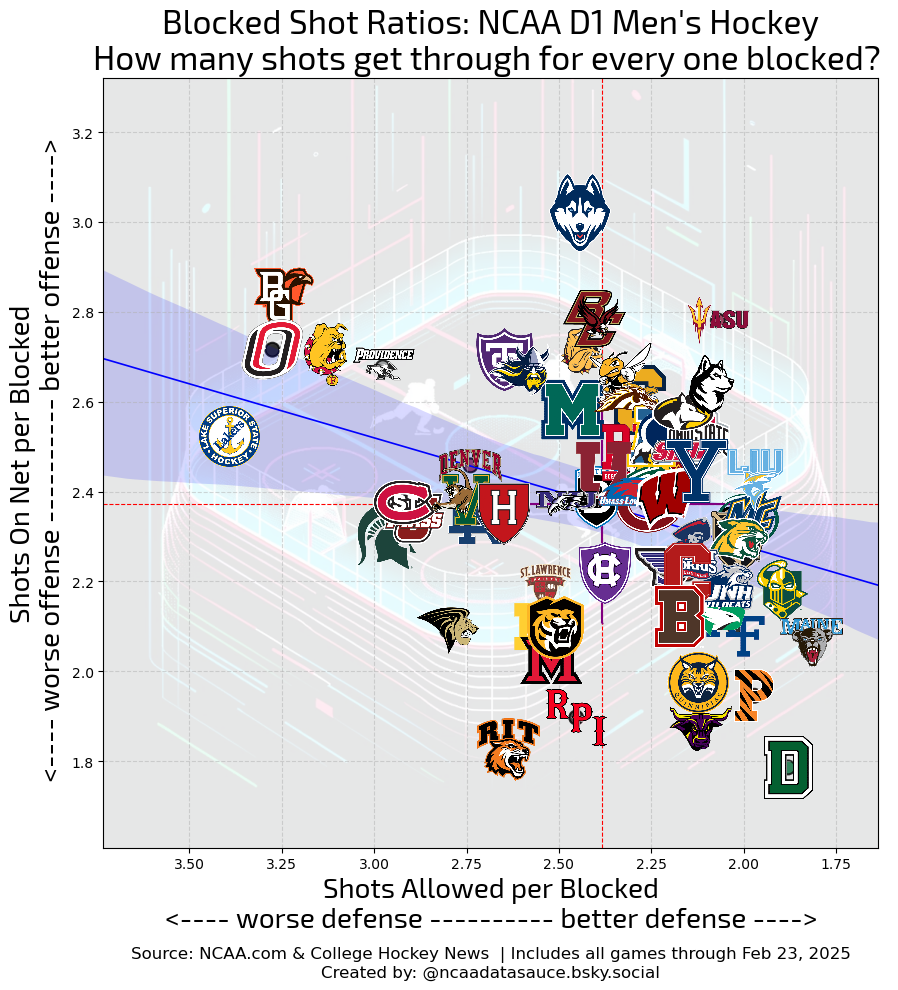

In [120]:
def create_blocked_shot_scatter(
    am_team_df_grouped, 
    title_text, 
    metric="count", 
    highlight_teams=None, 
    logo_mapping=None, 
    logo_folder=None,
    jitter=True,
    jitter_amount=global_jitter_amount):

    """
    Creates a scatter plot showing shots blocks for and against for each team.

    Parameters:
        am_team_df_grouped (pd.DataFrame): Dataframe containing TEAM ADVANCED STATS TOTALS data.
        highlight_teams (list): List of teams to highlight on the plot.
        logo_mapping (dict): Dictionary mapping teams to logo file names.
        logo_folder (str): Folder path containing the logo images.
        jitter (bool): Whether to apply jitter to overlapping points.
        jitter_amount (float): Maximum jitter distance applied to duplicate points.
    """
    # Columns to use for x and y axes
    x_col = 'D_Blocks'  # Shots the team has blocked
    total_allowed = 'Shots_Allowed'
    y_col = 'TOTAL_Block'  # Shots the team has had blocked by opponents
    total_on = 'TOTAL_Shots_ON'  # Shots on goal by the team

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figure_size)

    # Calculate derived statistics
    am_team_df_grouped['Blocked_Shot_Ratio'] = am_team_df_grouped[x_col] / am_team_df_grouped[y_col]
    am_team_df_grouped['Def_Block_v_Allowed'] = am_team_df_grouped['Shots_Allowed'] / am_team_df_grouped['D_Blocks']
    am_team_df_grouped['Shots_Blocked_v_On'] = am_team_df_grouped['TOTAL_Shots_ON'] / am_team_df_grouped['TOTAL_Block']

    # Determine correct x and y columns based on metric selection
    if metric == "count":
        plot_x = x_col
        plot_y = y_col
        title_message = ""  # No extra title message
    elif metric == "percentage":
        plot_x = 'Def_Block_v_Allowed'
        plot_y = 'Shots_Blocked_v_On'
        title_message = ""

    # **STEP 1: PLOT ALL TEAMS AS DOTS**
    scatter = ax.scatter(
        am_team_df_grouped[plot_x],
        am_team_df_grouped[plot_y],
        s=100,  # Marker size
        # c=[color_mapping[team][0] for team in am_team_df_grouped['Team']],
        c=[color_mapping.get(team, ['#808080'])[0] for team in am_team_df_grouped['Team']],

        edgecolors='black',
        alpha=0.8,
        linewidth=1.5,
        label="All Teams"
    )

    

    # **STEP 2: REMOVE DOTS AND REPLACE WITH LOGOS FOR HIGHLIGHTED TEAMS**
    if highlight_teams:
        highlight_df = am_team_df_grouped[am_team_df_grouped['Team'].isin(highlight_teams)]
        add_logos_to_plot(highlight_df, plot_x, plot_y, logo_mapping, logo_folder, ax, highlight_teams)




    # **Set Limits and Invert X-Axis for "percentage" metric**
    if metric == "percentage":
        ax.set_xlim(am_team_df_grouped[plot_x].max() * 1.1, am_team_df_grouped[plot_x].min() * 0.9)  # Reverse order
    else:
        ax.set_xlim(am_team_df_grouped[plot_x].min() * 0.9, am_team_df_grouped[plot_x].max() * 1.1)

    ax.set_ylim(am_team_df_grouped[plot_y].min() * 0.9, am_team_df_grouped[plot_y].max() * 1.1)

    # **Set Background Image**
    ax.imshow(bg_img, aspect='auto', extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], alpha=alpha_value)

    # **Add Grid Lines**
    ax.grid(True, linestyle='--', alpha=0.5)

    # Plot the average lines and standard deviation markers after setting the axis limits
    # Calculate means and standard deviations for the selected metric
    avg_x = am_team_df_grouped[plot_x].mean()
    avg_y = am_team_df_grouped[plot_y].mean()
    std_x = am_team_df_grouped[plot_x].std()
    std_y = am_team_df_grouped[plot_y].std()

    # Add dashed red average lines
    plt.axhline(y=avg_y, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_x, color='red', linestyle='--', linewidth=0.8)

    # Add error bar marker at the mean point with std deviation
    plt.errorbar(avg_x, avg_y, xerr=std_x, yerr=std_y, color='purple', 
                    fmt='o', capsize=1)
    
    # Add trend line (regression line with blue shaddow)
    # Ensure numeric values for regression plot
    am_team_df_grouped[plot_x] = pd.to_numeric(am_team_df_grouped[plot_x], errors='coerce')
    am_team_df_grouped[plot_y] = pd.to_numeric(am_team_df_grouped[plot_y], errors='coerce')

    sns.regplot(
        data=am_team_df_grouped, 
        x=plot_x, 
        y=plot_y, 
        scatter=False, 
        color='blue', 
        line_kws={"linewidth": 1.2, "linestyle": "-"}, 
        truncate=False  # Ensures line extends to full axis range
    )

    
    # **Set Labels and Title**
    if metric == "count":
        ax.set_xlabel('Defensive Blocks', fontdict=font_label_param)
        ax.set_ylabel('Offensive Blocked', fontdict=font_label_param)
    elif metric == "percentage":
        ax.set_xlabel('Shots Allowed per Blocked\n<---- worse defense ---------- better defense ---->', fontdict=font_label_param)
        ax.set_ylabel('Shots On Net per Blocked\n <---- worse offense ---------- better offense ---->', fontdict=font_label_param)

    ax.set_title(f"{title_text} {title_message}", fontdict=font_title_param)

    # add text to bottom of plot just under xaxis title with source
    # dynamically set the y position
    # if y_label has a line break in it set the position to be 0.1 lower than the y position of the y_label
    y_label = ax.get_ylabel()
    y_label_pos = ax.yaxis.get_label().get_position()[1]
    y_text_drop = -0.15 if '\n' in y_label else -0.1
    
    # add text to bottom of plot just under xaxis title with source    
    source_text = f"Source: NCAA.com & College Hockey News  | Includes all games through {last_game_date}\nCreated by: @ncaadatasauce.bsky.social"
    ax.text(0.5, y_text_drop, source_text, ha='center', va='center', transform=ax.transAxes, fontsize=size4)

    ## **Show the Plot**
    plt.show()


group_team = 'NCAA D1 Men\'s Hockey'
### Create the scatter plot for blocked shots with the specified parameters
create_blocked_shot_scatter(
    am_team_df_grouped, 
    title_text=f"Blocked Shots: {group_team}", 
    metric="count", 
    highlight_teams=teams_to_plot, 
    logo_mapping=logo_mapping, 
    logo_folder=logo_folder,
    jitter=True,
    jitter_amount=global_jitter_amount
)

create_blocked_shot_scatter(
    am_team_df_grouped, 
    title_text=f"Blocked Shot Ratios: {group_team}\nHow many shots get through for every one blocked?", 
    metric="percentage", 
    highlight_teams=teams_to_plot, 
    logo_mapping=logo_mapping, 
    logo_folder=logo_folder,
    jitter=True,
    jitter_amount=global_jitter_amount
)

## Post Power Play Plotting

In [121]:
# post_power_play_success.head()

In [122]:

def create_post_pp_outcome_plot(
    faceoff_df, 
    time_window, 
    metric="count", 
    highlight_teams=None, 
    logo_mapping=None, 
    logo_folder=None,
    jitter=True,
    jitter_amount=global_jitter_amount
):
    """
    Creates a scatter plot showing face-off outcomes based on goals scored vs. goals allowed.

    Parameters:
        faceoff_df (pd.DataFrame): Dataframe containing face-off goal outcome data.
        time_window (int): The number of seconds within which goals are considered.
        metric (str): Either 'count' for raw goal numbers or 'percentage' for goal percentages.
        highlight_teams (list): List of teams to highlight on the plot.
        logo_mapping (dict): Dictionary mapping teams to logo file names.
        logo_folder (str): Folder path containing the logo images.
        jitter (bool): Whether to apply jitter to overlapping points.
        jitter_amount (float): Maximum jitter distance applied to duplicate points.
    """
    # Determine column names based on time window and metric choice
    allowed_col = f"Allowed_within_{time_window}s"
    scored_col = f"Scored_within_{time_window}s"
    
    if metric == "percentage":
        allowed_col = f"Allowed_within_{time_window}s_pct"
        scored_col = f"Scored_within_{time_window}s_pct"

    # Filter out teams with missing data
    plot_df = post_power_play_success[['Team', allowed_col, scored_col]].dropna()

    # Apply jitter to duplicate points if enabled
    if jitter:
        plot_df = jitter_duplicates(plot_df, allowed_col, scored_col, jitter_amount)

    # Identify teams that have logos
    teams_with_logos = set(logo_mapping.keys()) if logo_mapping else set()

    # Filter out these teams before plotting
    scatter_df = plot_df[~plot_df['Team'].isin(teams_with_logos)]

    # Create figure and scatter plot with filtered teams
    # fig, ax = plt.subplots(figsize=figure_size)
    # sns.scatterplot(
    #     data=scatter_df, x=allowed_col, y=scored_col, 
    #     color='darkgrey', ax=ax, edgecolor='black'
    # )
    # Create figure and scatter plot
    fig, ax = plt.subplots(figsize=figure_size)
    sns.scatterplot(
        data=plot_df, x=allowed_col, y=scored_col, 
        color='darkgrey', ax=ax, edgecolor='black'
    )

    # Add trend line
    sns.regplot(
        data=plot_df, x=allowed_col, y=scored_col, 
        scatter=False, color='blue', ax=ax
    )
    # Highlight specific teams (excluding ones with logos)
    # if highlight_teams:
    #     highlight_no_logo_df = scatter_df[scatter_df['Team'].isin(highlight_teams)]
    #     sns.scatterplot(
    #         data=highlight_no_logo_df, x=allowed_col, y=scored_col, 
    #         color='red', ax=ax, edgecolor='black'
    #     )

    # Highlight specific teams
    if highlight_teams:
        highlight_df = plot_df[plot_df['Team'].isin(highlight_teams)]
        sns.scatterplot(
            data=highlight_df, x=allowed_col, y=scored_col, 
            color='red', ax=ax, edgecolor='black'
        )

    # Add logos and cover up underlying dots
    if logo_mapping and logo_folder:
        for team in highlight_teams or []:
            team_data = plot_df[plot_df['Team'] == team]
            if not team_data.empty:
                x, y = team_data[allowed_col].values[0], team_data[scored_col].values[0]
                logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))

                if os.path.exists(logo_path):
                    try:
                        # Cover up the dot with a white circle
                        ax.add_patch(plt.Circle((x, y), radius=0.05, color='white', zorder=1))

                        # Add the team logo on top
                        logo_img = plt.imread(logo_path)
                        imagebox = OffsetImage(logo_img, zoom=0.15)
                        ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(0, 0), boxcoords="offset points")
                        ax.add_artist(ab)
                    except Exception as e:
                        print(f"Error adding logo for {team}: {e}")

    # Automatically adjust axis limits for percentage scale
    if metric == "percentage":
        x_min, x_max = plot_df[allowed_col].min(), plot_df[allowed_col].max()
        y_min, y_max = plot_df[scored_col].min(), plot_df[scored_col].max()
        padding = 0.01  # Add 1% padding
        ax.set_xlim(x_min - padding, x_max + padding)
        ax.set_ylim(y_min - padding, y_max + padding)


    # Labels and Title
    x_label = f"Goals Allowed"
    y_label = f"Goals Scored "
    if metric == "percentage":
        x_label += " (% of Total Allowed)"
        y_label += " (% of Total Scored)"

    # If Metric is Percentage, reformat label as from 0.000 to 0.0%
    if metric == "percentage":
        ax.xaxis.set_major_formatter(PercentFormatter(1))
        ax.yaxis.set_major_formatter(PercentFormatter(1))


    


    ###### ADD THE BACKGROUND IMAGE
    # Get the boundries of the plot (xmin, xmax, ymin, ymax)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    new_ymax = ymax

    new_xmax = xmax
    # Set the background image
    plt.imshow(bg_img, aspect='auto', extent=[xmin, xmax, ymin, new_ymax], zorder=1, alpha=alpha_value)

    

    # add gridlines
    ax.grid(True, linestyle='--', alpha=0.5)
    # Set the axis limits

    ax.set_xlabel(x_label, fontdict=font_label_param)
    ax.set_ylabel(y_label, fontdict=font_label_param)
    ax.set_title(f"Post Power Play Outcomes ({time_window} Second Window)", fontdict=font_title_param)

    # add text to bottom of plot just under xaxis title with source
    source_text = f"Source: NCAA.com Play-by-Play Data | Includes all games through {last_game_date}\nCreated by: @ncaadatasauce.bsky.social"
    ax.text(0.5, -0.1, source_text, ha='center', va='center', transform=ax.transAxes, fontsize=size4)
    

    # Save the Plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"power_play_momentum_{time_window}_{metric}.png"), dpi=dpi)


    # Save and show the plot
    plt.show()

In [123]:
### SET TEAMS TO HIGHLIGHT
# teams_to_plot = conference_teams_mens['NCAA At-Large Contenders']
teams_to_plot = conference_teams_mens['Full 64']

In [124]:
# Call the function

# # 5 Sec by Count
# create_post_pp_outcome_plot(
#     post_power_play_success, 
#     time_window=5, 
#     metric="count", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping, 
#     logo_folder=logo_folder,
#     jitter=True,
#     jitter_amount=0.2
# )

# ## 10 Sec by Count
# create_post_pp_outcome_plot(
#     post_power_play_success, 
#     time_window=10, 
#     metric="percentage", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping, 
#     logo_folder=logo_folder,
#     jitter=False,
#     jitter_amount=0.2
# )

# # 10 Sec by Count
# create_post_pp_outcome_plot(
#     post_power_play_success, 
#     time_window=10, 
#     metric="count", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping, 
#     logo_folder=logo_folder,
#     jitter=True,
#     jitter_amount=0.2
# )

# ## 10 Sec by Percentage
# create_post_pp_outcome_plot(
#     post_power_play_success, 
#     time_window=10, 
#     metric="percentage", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping, 
#     logo_folder=logo_folder,
#     jitter=False,
#     jitter_amount=0.2
# )

# # 15 Sec by Count
# create_post_pp_outcome_plot(
#     post_power_play_success, 
#     time_window=15, 
#     metric="count", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping, 
#     logo_folder=logo_folder,
#     jitter=True,
#     jitter_amount=0.2
# )

# ## 15 Sec by Percentage
# create_post_pp_outcome_plot(
#     post_power_play_success, 
#     time_window=15, 
#     metric="percentage", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping, 
#     logo_folder=logo_folder,
#     jitter=False,
#     jitter_amount=0.2
# )

# # 30 Sec by Count
# create_post_pp_outcome_plot(
#     post_power_play_success, 
#     time_window=30, 
#     metric="count", 
#     highlight_teams=conference_teams_mens['Full 64'], 
#     logo_mapping=logo_mapping, 
#     logo_folder=logo_folder,
#     jitter=True,
#     jitter_amount=0.2
# )

# ## 30 Sec by Percentage
# create_post_pp_outcome_plot(
#     post_power_play_success, 
#     time_window=30, 
#     metric="percentage", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping, 
#     logo_folder=logo_folder,
#     jitter=False,
#     jitter_amount=0.2
# )

## Faceoff Outcome Plotting Function

### Faceoff Plotting Version 1.0

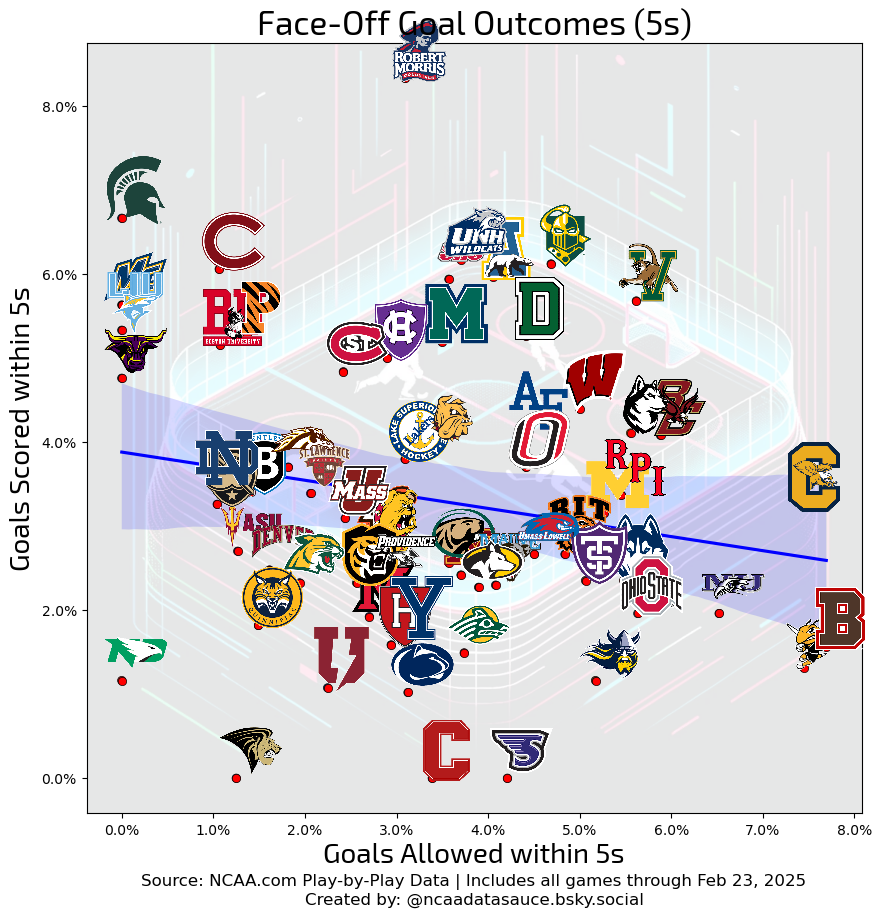

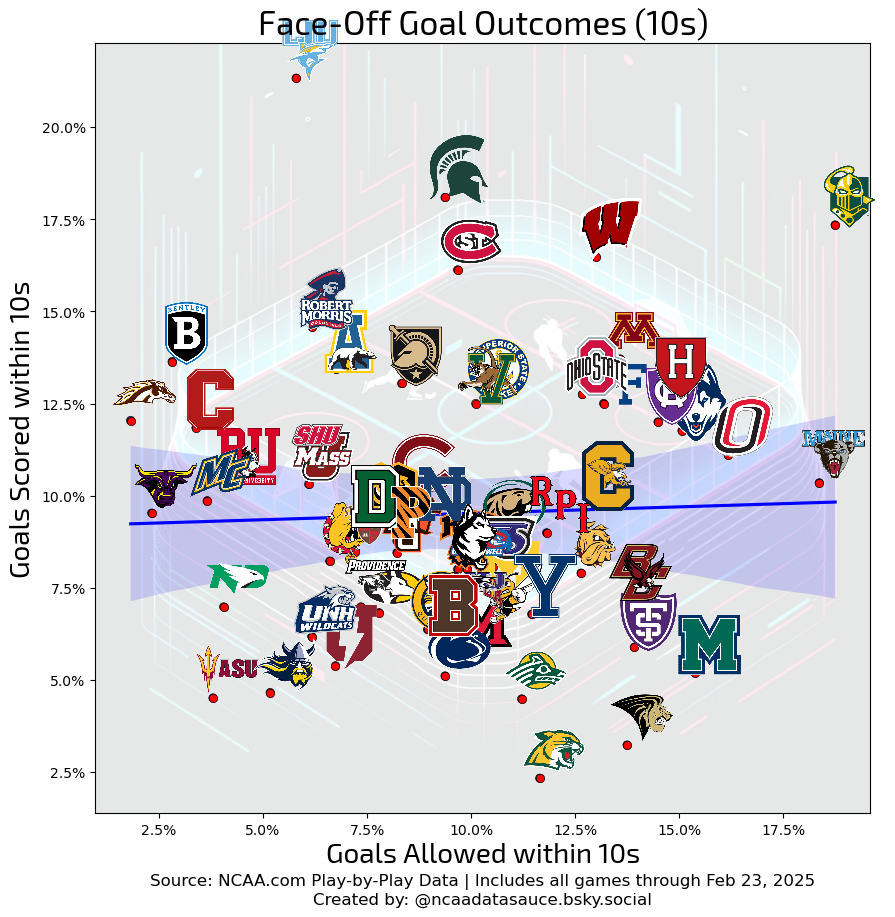

In [125]:
import numpy as np

def jitter_duplicates(plot_df, x_col, y_col, jitter_amount=0.2):
    """
    Adds slight jitter to duplicate (x, y) coordinate pairs to prevent overlapping.
    
    Parameters:
        plot_df (pd.DataFrame): Dataframe containing x and y coordinates.
        x_col (str): Name of the x-axis column.
        y_col (str): Name of the y-axis column.
        jitter_amount (float): Maximum jitter to apply (default 0.2).
        
    Returns:
        pd.DataFrame: Dataframe with adjusted coordinates.
    """
    coord_counts = plot_df.groupby([x_col, y_col]).size().reset_index(name='count')
    
    # Apply jitter to duplicates
    for _, row in coord_counts.iterrows():
        if row['count'] > 1:
            mask = (plot_df[x_col] == row[x_col]) & (plot_df[y_col] == row[y_col])
            num_duplicates = mask.sum()
            jitter_x = np.linspace(-jitter_amount, jitter_amount, num_duplicates)
            jitter_y = np.linspace(-jitter_amount, jitter_amount, num_duplicates)
            np.random.shuffle(jitter_x)
            np.random.shuffle(jitter_y)
            plot_df.loc[mask, x_col] += jitter_x
            plot_df.loc[mask, y_col] += jitter_y
    
    return plot_df

def create_faceoff_outcome_plot(
    faceoff_df, 
    time_window, 
    metric="count", 
    highlight_teams=None, 
    logo_mapping=None, 
    logo_folder=None,
    jitter=True,
    jitter_amount=0.2
):
    """
    Creates a scatter plot showing face-off outcomes based on goals scored vs. goals allowed.

    Parameters:
        faceoff_df (pd.DataFrame): Dataframe containing face-off goal outcome data.
        time_window (int): The number of seconds within which goals are considered.
        metric (str): Either 'count' for raw goal numbers or 'percentage' for goal percentages.
        highlight_teams (list): List of teams to highlight on the plot.
        logo_mapping (dict): Dictionary mapping teams to logo file names.
        logo_folder (str): Folder path containing the logo images.
        jitter (bool): Whether to apply jitter to overlapping points.
        jitter_amount (float): Maximum jitter distance applied to duplicate points.
    """
    # Determine column names based on time window and metric choice
    allowed_col = f"Allowed_within_{time_window}s"
    scored_col = f"Scored_within_{time_window}s"
    
    if metric == "percentage":
        allowed_col = f"Allowed_within_{time_window}s_pct"
        scored_col = f"Scored_within_{time_window}s_pct"

    # Filter out teams with missing data
    plot_df = faceoff_df[['Team', allowed_col, scored_col]].dropna()

    # Apply jitter to duplicate points if enabled
    if jitter:
        plot_df = jitter_duplicates(plot_df, allowed_col, scored_col, jitter_amount)

    # Create figure and scatter plot
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(
        data=plot_df, x=allowed_col, y=scored_col, 
        # color='darkgrey',
        c=[color_mapping.get(team, ['#808080'])[0] for team in am_team_df_grouped['Team']],
        ax=ax, edgecolor='black'
    )

    # Add trend line
    sns.regplot(
        data=plot_df, x=allowed_col, y=scored_col, 
        scatter=False, color='blue', ax=ax
    )

    # Highlight specific teams
    if highlight_teams:
        highlight_df = plot_df[plot_df['Team'].isin(highlight_teams)]
        sns.scatterplot(
            data=highlight_df, x=allowed_col, y=scored_col, 
            color='red', ax=ax, edgecolor='black'
        )

    # Add logos if applicable
    if logo_mapping and logo_folder:
        for team in highlight_teams or []:
            team_data = plot_df[plot_df['Team'] == team]
            if not team_data.empty:
                x, y = team_data[allowed_col].values[0], team_data[scored_col].values[0]
                logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
                if os.path.exists(logo_path):
                    try:
                        logo_img = plt.imread(logo_path)
                        imagebox = OffsetImage(logo_img, zoom=0.15)
                        ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(10, 20), boxcoords="offset points")
                        ax.add_artist(ab)
                    except Exception as e:
                        print(f"Error adding logo for {team}: {e}")

    # Labels and Title
    x_label = f"Goals Allowed within {time_window}s"
    y_label = f"Goals Scored within {time_window}s"
    if metric == "percentage":
        x_label += ""
        y_label += ""
        # If Metric is Percentage, reformat label as from 0.000 to 0.0%
        ax.xaxis.set_major_formatter(PercentFormatter(1))
        ax.yaxis.set_major_formatter(PercentFormatter(1))

    

    ax.set_xlabel(x_label, fontdict=font_label_param)
    ax.set_ylabel(y_label, fontdict=font_label_param)
    ax.set_title(f"Face-Off Goal Outcomes ({time_window}s)", fontdict=font_title_param)

    # add text to bottom of plot just under xaxis title with source
    source_text = f"Source: NCAA.com Play-by-Play Data | Includes all games through {last_game_date}\nCreated by: @ncaadatasauce.bsky.social"
    ax.text(0.5, -0.1, source_text, ha='center', va='center', transform=ax.transAxes, fontsize=size4)
    
        # Get the boundries of the plot (xmin, xmax, ymin, ymax)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    new_ymax = ymax

    new_xmax = xmax
    # Set the background image
    plt.imshow(bg_img, aspect='auto', extent=[xmin, xmax, ymin, new_ymax], zorder=0, alpha=alpha_value)

    # Save and show the plot
    plt.show()

# Example usage with jitter enabled:
create_faceoff_outcome_plot(
    faceoff_df=face_off_goal_success, 
    time_window=5, 
    metric="percentage", 
    highlight_teams=teams_to_plot,
    logo_mapping=logo_mapping, 
    logo_folder=logo_folder,
    # logo_mapping={},  # Replace with actual mapping
    # logo_folder="",  # Replace with actual path
    jitter=True,  # Enable jittering
    jitter_amount=0.2  # Adjust this value to control the spread of points
)

# Example usage with jitter enabled:
create_faceoff_outcome_plot(
    faceoff_df=face_off_goal_success, 
    time_window=10, 
    metric="percentage", 
    highlight_teams=teams_to_plot,
    logo_mapping=logo_mapping, 
    logo_folder=logo_folder,
    # logo_mapping={},  # Replace with actual mapping
    # logo_folder="",  # Replace with actual path
    jitter=True,  # Enable jittering
    jitter_amount=0.2  # Adjust this value to control the spread of points
)


In [126]:
# ## Jitter or Offset Overlapping Points
# def jitter_duplicates(plot_df, x_col, y_col, jitter_amount=0.2):
#     """
#     Adds slight jitter to duplicate (x, y) coordinate pairs to prevent overlapping.
    
#     Parameters:
#         plot_df (pd.DataFrame): Dataframe containing x and y coordinates.
#         x_col (str): Name of the x-axis column.
#         y_col (str): Name of the y-axis column.
#         jitter_amount (float): Maximum jitter to apply (default 0.2).
        
#     Returns:
#         pd.DataFrame: Dataframe with adjusted coordinates.
#     """
#     coord_counts = plot_df.groupby([x_col, y_col]).size().reset_index(name='count')
    
#     # Apply jitter to duplicates
#     for _, row in coord_counts.iterrows():
#         if row['count'] > 1:
#             mask = (plot_df[x_col] == row[x_col]) & (plot_df[y_col] == row[y_col])
#             num_duplicates = mask.sum()
#             jitter_x = np.linspace(-jitter_amount, jitter_amount, num_duplicates)
#             jitter_y = np.linspace(-jitter_amount, jitter_amount, num_duplicates)
#             np.random.shuffle(jitter_x)
#             np.random.shuffle(jitter_y)
#             plot_df.loc[mask, x_col] += jitter_x
#             plot_df.loc[mask, y_col] += jitter_y
    
#     return plot_df

# def create_faceoff_outcome_plot(
#     faceoff_df, 
#     time_window, 
#     metric="count", 
#     highlight_teams=None, 
#     logo_mapping=None, 
#     logo_folder=None,
#     jitter=True,
#     jitter_amount=0.2
# ):
#     """
#     Creates a scatter plot showing face-off outcomes based on goals scored vs. goals allowed.

#     Parameters:
#         faceoff_df (pd.DataFrame): Dataframe containing face-off goal outcome data.
#         time_window (int): The number of seconds within which goals are considered.
#         metric (str): Either 'count' for raw goal numbers or 'percentage' for goal percentages.
#         highlight_teams (list): List of teams to highlight on the plot.
#         logo_mapping (dict): Dictionary mapping teams to logo file names.
#         logo_folder (str): Folder path containing the logo images.
#         jitter (bool): Whether to apply jitter to overlapping points.
#         jitter_amount (float): Maximum jitter distance applied to duplicate points.
#     """
#     # Determine column names based on time window and metric choice
#     allowed_col = f"Allowed_within_{time_window}s"
#     scored_col = f"Scored_within_{time_window}s"
    
#     if metric == "percentage":
#         allowed_col = f"Allowed_within_{time_window}s_pct"
#         scored_col = f"Scored_within_{time_window}s_pct"

#     # Filter out teams with missing data
#     # plot_df = faceoff_df[['Team', allowed_col, scored_col]].dropna()
#     plot_df = faceoff_df[['Team', allowed_col, scored_col]].fillna(0)


#     # Apply jitter to duplicate points if enabled
#     if jitter:
#         plot_df = jitter_duplicates(plot_df, allowed_col, scored_col, jitter_amount)

#     # Identify teams that have logos
#     teams_with_logos = set(logo_mapping.keys()) if logo_mapping else set()

#     # Filter out these teams before plotting
#     scatter_df = plot_df[~plot_df['Team'].isin(teams_with_logos)]

#     # Create figure and scatter plot with filtered teams
#     # fig, ax = plt.subplots(figsize=figure_size)
#     # sns.scatterplot(
#     #     data=scatter_df, x=allowed_col, y=scored_col, 
#     #     color='darkgrey', ax=ax, edgecolor='black'
#     # )
#     # Create figure and scatter plot
#     fig, ax = plt.subplots(figsize=figure_size)
#     sns.scatterplot(
#         data=plot_df, x=allowed_col, y=scored_col, 
#         color='darkgrey', ax=ax, edgecolor='black'
#     )

#     # Add trend line
#     sns.regplot(
#         data=plot_df, x=allowed_col, y=scored_col, 
#         scatter=False, color='blue', ax=ax
#     )
#     # Highlight specific teams (excluding ones with logos)
#     # if highlight_teams:
#     #     highlight_no_logo_df = scatter_df[scatter_df['Team'].isin(highlight_teams)]
#     #     sns.scatterplot(
#     #         data=highlight_no_logo_df, x=allowed_col, y=scored_col, 
#     #         color='red', ax=ax, edgecolor='black'
#     #     )

#     # Highlight specific teams
#     if highlight_teams:
#         highlight_df = plot_df[plot_df['Team'].isin(highlight_teams)]
#         sns.scatterplot(
#             data=highlight_df, x=allowed_col, y=scored_col, 
#             color='red', ax=ax, edgecolor='black'
#         )

#     # Add logos and cover up underlying dots
#     if logo_mapping and logo_folder:
#         for team in highlight_teams or []:
#             team_data = plot_df[plot_df['Team'] == team]
#             if not team_data.empty:
#                 x, y = team_data[allowed_col].values[0], team_data[scored_col].values[0]
#                 logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))

#                 if os.path.exists(logo_path):
#                     try:
#                         # Cover up the dot with a white circle
#                         ax.add_patch(plt.Circle((x, y), radius=0.05, color='white', zorder=1))

#                         # Add the team logo on top
#                         logo_img = plt.imread(logo_path)
#                         imagebox = OffsetImage(logo_img, zoom=0.15)
#                         ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(0, 0), boxcoords="offset points")
#                         ax.add_artist(ab)
#                     except Exception as e:
#                         print(f"Error adding logo for {team}: {e}")

#     # Automatically adjust axis limits for percentage scale
#     if metric == "percentage":
#         x_min, x_max = plot_df[allowed_col].min(), plot_df[allowed_col].max()
#         y_min, y_max = plot_df[scored_col].min(), plot_df[scored_col].max()
#         padding = 0.01  # Add 1% padding
#         ax.set_xlim(x_min - padding, x_max + padding)
#         ax.set_ylim(y_min - padding, y_max + padding)


#     # Labels and Title
#     x_label = f"Goals Allowed"
#     y_label = f"Goals Scored "
#     if metric == "percentage":
#         x_label += " (% of Total Allowed)"
#         y_label += " (% of Total Scored)"

    


#     ###### ADD THE BACKGROUND IMAGE
#     # Get the boundries of the plot (xmin, xmax, ymin, ymax)
#     xmin, xmax = ax.get_xlim()
#     ymin, ymax = ax.get_ylim()
#     new_ymax = ymax

#     new_xmax = xmax
#     # Set the background image
#     plt.imshow(bg_img, aspect='auto', extent=[xmin, xmax, ymin, new_ymax], zorder=1, alpha=alpha_value)

    

#     # add gridlines
#     ax.grid(True, linestyle='--', alpha=0.5)
#     # Set the axis limits

#     ax.set_xlabel(x_label, fontdict=font_label_param)
#     ax.set_ylabel(y_label, fontdict=font_label_param)
#     ax.set_title(f"Face-Off Outcomes ({time_window} Second Window)", fontdict=font_title_param)

#     # add text to bottom of plot just under xaxis title with source
#     source_text = f"Source: NCAA.com Play-by-Play Data | Includes all games through {last_game_date}\nCreated by: @ncaadatasauce.bsky.social"
#     ax.text(0.5, -0.1, source_text, ha='center', va='center', transform=ax.transAxes, fontsize=size4)
    

#     # Save the Plot
#     plt.tight_layout()
#     plt.savefig(os.path.join(output_folder, f"faceoff_outcome_{time_window}_{metric}.png"), dpi=dpi)


#     # Save and show the plot
#     plt.show()


# # Example usage with jitter enabled:
# create_faceoff_outcome_plot(
#     faceoff_df=face_off_goal_success, 
#     time_window=5, 
#     metric="percentage", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping,  # Replace with actual mapping
#     logo_folder=logo_folder,  # Replace with actual path
#     jitter=True,  # Enable jittering
#     jitter_amount=0.15  # Adjust this value to control the spread of points
# )

# # Example usage with jitter enabled:
# create_faceoff_outcome_plot(
#     faceoff_df=face_off_goal_success, 
#     time_window=5, 
#     metric="count", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping,  # Replace with actual mapping
#     logo_folder=logo_folder,  # Replace with actual path
#     jitter=True,  # Enable jittering
#     jitter_amount=0.2  # Adjust this value to control the spread of points
# )

# # Example usage with jitter enabled:
# create_faceoff_outcome_plot(
#     faceoff_df=face_off_goal_success, 
#     time_window=10, 
#     metric="percentage", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping,  # Replace with actual mapping
#     logo_folder=logo_folder,  # Replace with actual path
#     jitter=True,  # Enable jittering
#     jitter_amount=0.15  # Adjust this value to control the spread of points
# )

# # Example usage with jitter enabled:
# create_faceoff_outcome_plot(
#     faceoff_df=face_off_goal_success, 
#     time_window=10, 
#     metric="count", 
#     highlight_teams=conference_teams_mens['ECAC'], 
#     logo_mapping=logo_mapping,  # Replace with actual mapping
#     logo_folder=logo_folder,  # Replace with actual path
#     jitter=True,  # Enable jittering
#     jitter_amount=0.2  # Adjust this value to control the spread of points
# )
